In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!ls '/content/gdrive/My Drive/Datasets'

celebFace.zip  df_par_attr.csv	images	img_test.zip


In [ ]:
!mkdir data

In [ ]:
 !unzip '/content/gdrive/My Drive/Datasets/celebFace.zip' -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197617.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197618.jpg  
  inflating: data/img_align_celeba/img_

In [ ]:
import pandas as pd
import numpy as np
import tarfile
import io
import os
# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split
from skimage import io
import PIL
import torch
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, ToPILImage, Normalize, Compose
import torch.nn.functional as F
from IPython.display import display

#from torchvision.transforms import ToTensor, ToPILImage
# PyTorch libraries and modules
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.optim as optim

from timeit import default_timer as timer  
import seaborn as sns

In [ ]:
#import torch
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on the GPU")
else:
  device = torch.device("cpu")
  print("Running on the CPU")


Running on the GPU


In [ ]:
CUDA_LAUNCH_BLOCKING =1

In [ ]:
main_folder = '/content/data/img_align_celeba'
images_folder ='/content/data/img_align_celeba/img_align_celeba/'
batch_size = 128
epochs = 10

train_img = pd.read_csv('/content/data/img_align_celeba/img_align_celeba/df_train_attr.csv')
valid_img = pd.read_csv('/content/data/img_align_celeba/img_align_celeba/df_valid_attr.csv')

In [ ]:
#Cleaning the training images
train_img.head()
train_img.dtypes

train_img =train_img.dropna()

In [ ]:
train_img.head()

,image_id,Black_Hair,Blond_Hair,Brown_Hair,Gray_Hair,Hair_color
0,000001.jpg,0.0,0.0,1.0,0.0,2.0
1,000002.jpg,0.0,0.0,1.0,0.0,2.0
2,000006.jpg,0.0,0.0,1.0,0.0,2.0
3,000007.jpg,1.0,0.0,0.0,0.0,1.0
4,000008.jpg,1.0,0.0,0.0,0.0,1.0


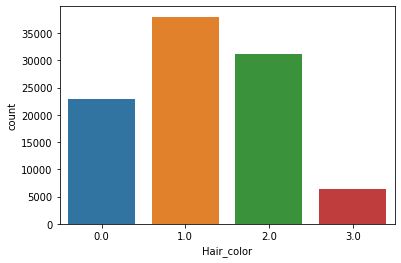

In [ ]:
#training images label distribution
sns.countplot(x='Hair_color',data = train_img)

In [ ]:
train_img = train_img.astype({'Black_Hair':'int64','Blond_Hair':'int64','Brown_Hair':'int64'
,'Gray_Hair':'int64','Hair_color':'int64'})
#train_img['Hair_color'] = train_img['Hair_color'].astype(int)
train_img.head()

,image_id,Black_Hair,Blond_Hair,Brown_Hair,Gray_Hair,Hair_color
0,000001.jpg,0,0,1,0,2
1,000002.jpg,0,0,1,0,2
2,000006.jpg,0,0,1,0,2
3,000007.jpg,1,0,0,0,1
4,000008.jpg,1,0,0,0,1


In [ ]:
#cleaning the validation csv
valid_img = valid_img.dropna()
valid_img.head()

,image_id,Black_Hair,Blond_Hair,Brown_Hair,Gray_Hair,Hair_color
0,162772.jpg,1.0,0.0,0.0,0.0,1.0
1,162773.jpg,0.0,0.0,1.0,0.0,2.0
2,162774.jpg,0.0,0.0,1.0,0.0,2.0
3,162775.jpg,1.0,0.0,0.0,0.0,1.0
4,162776.jpg,1.0,0.0,0.0,0.0,1.0


In [ ]:
valid_img = valid_img.astype({'Black_Hair':'int64','Blond_Hair':'int64','Brown_Hair':'int64'
,'Gray_Hair':'int64','Hair_color':'int64'})
valid_img.head()

,image_id,Black_Hair,Blond_Hair,Brown_Hair,Gray_Hair,Hair_color
0,162772.jpg,1,0,0,0,1
1,162773.jpg,0,0,1,0,2
2,162774.jpg,0,0,1,0,2
3,162775.jpg,1,0,0,0,1
4,162776.jpg,1,0,0,0,1


In [ ]:
valid_img.dtypes

image_id      object
Black_Hair     int64
Blond_Hair     int64
Brown_Hair     int64
Gray_Hair      int64
Hair_color     int64
dtype: object

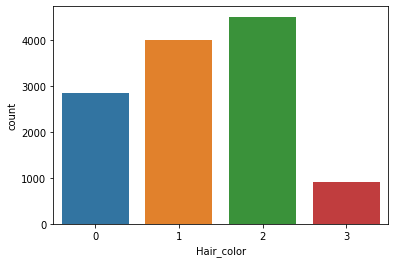

In [ ]:
sns.countplot(x='Hair_color',data = valid_img)

In [ ]:
class Celeb(Dataset):
  def __init__(self, csv_file,img_dir, transform=None):
    self.img_dir = img_dir
    self.annotations = csv_file
    self.transform = transform

  def __len__(self):
      #print(len(self.annotations))
      return len(self.annotations)
    
  def __getitem__(self, index):
      img_path = os.path.join(self.img_dir, self.annotations.iloc[index,0])
      #img_name = self.img_path[index]
      img = Image.open(img_path)
      y_label = torch.tensor(int (self.annotations.iloc[index,-1]))

      if self.transform:
        img = self.transform(img)

        return (img, y_label)
      

In [ ]:
# Creating tensors for the images and their labels
train_data = Celeb(csv_file = train_img, img_dir = images_folder,
                       transform = transforms.Compose([transforms.Resize(178),transforms.CenterCrop(178)
                                                       ,transforms.ToTensor()]))

valid_data = Celeb(csv_file = valid_img, img_dir = images_folder,
                       transform = transforms.Compose([transforms.Resize(178),transforms.CenterCrop(178),
                                                        transforms.ToTensor()]))

tensor(2)
tensor(2)
tensor(2)
tensor(1)
tensor(1)


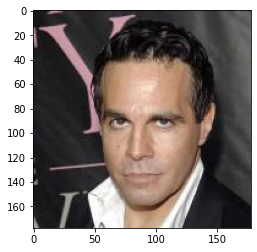

In [ ]:

from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
# num = 50
#from IPython.display import Image
# sample = train_data[num]
# fig = plt.figure()
# for i in sample:""
for i in range(len(train_data)):
    img,label = train_data[i]
    img = img.permute(1,2,0)
    #Image.open(img)
    imshow(img)
    print(label)
    #print(i, sample['image_id'].size())#, sample['landmarks'].size())

    if i == 4:
        break

In [ ]:
# loading the data
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)

valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle = True)

In [ ]:
# Creating the model
class Feature_Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,32,3, stride = 1)
    self.batch1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(32,64,5,stride=1)
    self.batch2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(64,128,3,stride=1)
    self.batch3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(2,2)
    self.conv4 = nn.Conv2d(128, 128, 5, stride=1)
    self.batch4 = nn.BatchNorm2d(128)
    self.pool4 = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(128 * 8 * 8 ,1024)  
    self.drop1 = nn.Dropout(p=0.4)
    self.fc2 = nn.Linear(1024,128)
    self.drop2 = nn.Dropout(p=0.25)
    self.fc3 = nn.Linear(128,4)

  def forward(self,x):
    #x1  =   self.conv1(x)
    x   =   self.pool1(F.relu(self.batch1((self.conv1(x)))))
    x   =   self.pool2(F.relu(self.batch2((self.conv2(x)))))
    x   =   self.pool3(F.relu(self.batch3((self.conv3(x)))))
    x   =   self.pool4(F.relu(self.batch4((self.conv4(x)))))
    x   =   x.view(-1, 128 * 8 * 8)
    x   =   self.drop1(x) 
    x   =   F.relu(self.fc1(x))
    x   =   self.drop2(x) 
    x   =   F.relu(self.fc2(x))
    x   =   self.fc3(x)
    return x
print(Feature_Model())


Feature_Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_featur

In [ ]:
model1 = Feature_Model()
model = model1.to(device)

In [ ]:
def train():  # loop over the dataset multiple times
    optimizer = torch.optim.SGD(model.parameters(),lr = 0.001, momentum=0.9)   
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    total_train = 0
    correct_train = 0
    running_loss = 0
    for i,(img, labels) in enumerate(train_loader):

        img = img.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss.item()
        #accuracy
        _, predicted = torch.max(output.data, 1)
        predicted = predicted
        total_train += labels.size(0)
        correct_train += predicted.eq(labels.data).sum().item()
        train_accuracy = 100 * correct_train / total_train

    losses.append(loss.item())
    train_acy.append(train_accuracy)
    return (train_accuracy,loss.item())


In [ ]:
#n_samp = 5120
def valid(epochs):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        with torch.no_grad():
            for i,(img, labels) in enumerate(valid_loader):
                # if i>=n_samp:
                #   break
                img = img.to(device)
                labels = labels.to(device)
                outputs = model(img)
                _, predicted = torch.max(outputs.data, 1)
                predicted = predicted
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                acc = 100*correct/total
    valid_acy.append(acc)
    return acc

In [ ]:
!cd data/img_align_celeba/
!mkdir img_test

In [ ]:
 !unzip '/content/gdrive/My Drive/Datasets/img_test.zip' -d img_test

Archive:  /content/gdrive/My Drive/Datasets/img_test.zip
  inflating: img_test/img_test/202453.jpg  
  inflating: img_test/img_test/202454.jpg  
  inflating: img_test/img_test/202455.jpg  
  inflating: img_test/img_test/202456.jpg  
  inflating: img_test/img_test/202457.jpg  
  inflating: img_test/img_test/202458.jpg  
  inflating: img_test/img_test/202459.jpg  
  inflating: img_test/img_test/202460.jpg  
  inflating: img_test/img_test/202461.jpg  
  inflating: img_test/img_test/202462.jpg  
  inflating: img_test/img_test/202463.jpg  
  inflating: img_test/img_test/202464.jpg  
  inflating: img_test/img_test/202465.jpg  
  inflating: img_test/img_test/202466.jpg  
  inflating: img_test/img_test/202467.jpg  
  inflating: img_test/img_test/202468.jpg  
  inflating: img_test/img_test/202469.jpg  
  inflating: img_test/img_test/202470.jpg  
  inflating: img_test/img_test/202471.jpg  
  inflating: img_test/img_test/202472.jpg  
  inflating: img_test/img_test/202473.jpg  
  inflating: img_te

In [ ]:
classes = ('Blond Hair','Black Hair','Brown Hair','Gray Hair')
def predict(img_test_dir):
    model.eval()
    #Loading the model
    model1 = torch.load('/content/model.pt',map_location = 'cpu')
    print(model1)
    img = Image.open(img_test_dir)
    with torch.no_grad():
        trans1 = transforms.Compose([transforms.Resize(178),transforms.CenterCrop(178)
                                                       ,transforms.ToTensor()])
        img_tensor = trans1(img) #shape = [3, 32, 32]
        #Image Transformation
        trans = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        img_tensor = trans(img_tensor)
        print(img_tensor.shape)
        
        single_image_batch = img_tensor.unsqueeze(0) 
        outputs = model1(single_image_batch)
        _, predicted = torch.max(outputs.data, 1)
        class_id = predicted[0].item()
        predicted_class = classes[predicted[0].item()]
        print("Predicted Class : {}".format(predicted_class))
        display(img)

Training for 10 epochs
Epoch 0, train Loss: 0.340 Training Accuracy 82.41858670376425: Valid Accuracy 85.73757131214344
GPU time:  483.4965442130001
Epoch 1, train Loss: 0.195 Training Accuracy 88.11929446887153: Valid Accuracy 86.7563162184189
GPU time:  468.92667761799976
Epoch 2, train Loss: 0.172 Training Accuracy 90.7655439230699: Valid Accuracy 89.23390383048084
GPU time:  467.2274654019993
Epoch 3, train Loss: 0.089 Training Accuracy 91.99727860762194: Valid Accuracy 90.76609616951916
GPU time:  468.02489340899956
Epoch 4, train Loss: 0.313 Training Accuracy 92.64919424445822: Valid Accuracy 89.98370008149959
GPU time:  467.2992211339997
Epoch 5, train Loss: 0.359 Training Accuracy 93.30314077112887: Valid Accuracy 91.55664221678892
GPU time:  467.0707336129999
Epoch 6, train Loss: 0.118 Training Accuracy 93.89717604768529: Valid Accuracy 91.49959250203749
GPU time:  465.78152734300056
Epoch 7, train Loss: 0.136 Training Accuracy 94.66383696016409: Valid Accuracy 91.882640586797

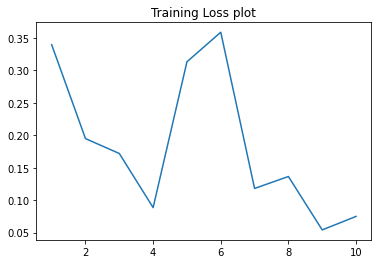

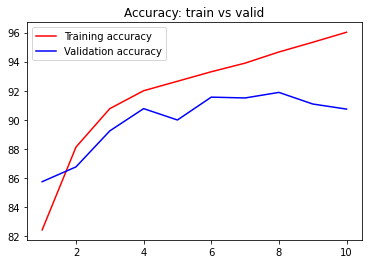

In [ ]:
print("Training for {} epochs".format(epochs))
main_time = timer()
losses = []
train_acy = []
valid_acy = []
for epoch in range(epochs):
    start = timer()
    (train_model,loss_tr)=train()
    valid_acc = valid(epochs)

    print('Epoch {}, train Loss: {:.3f}'.format(epoch ,loss_tr), 'Training Accuracy {}:' .format(train_model), 'Valid Accuracy {}'.format(valid_acc))
    print("GPU time: ",timer()-start)
print("Model successfully saved ")
torch.save(model, 'model.pt')
print("Time taken for",epochs,"epochs is",timer()-main_time,"seconds")

epoch = range(1,len(losses)+1)
plt.title("Training Loss plot")
plt.plot(epoch,losses)

plt.figure()
plt.title("Accuracy: train vs valid")
plt.plot(epoch,train_acy,'red',label='Training accuracy')
plt.plot(epoch,valid_acy,'blue',label='Validation accuracy')
plt.legend()
plt.show()


Feature_Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_featur

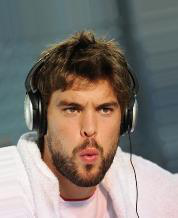

In [ ]:
predict('/content/img_test/img_test/202568.jpg')
